# Transformer model - Machine Translation

### Tutorial Topics
- Transformer model

### Software Requirements
This notebook was last tested on:
- Python (3.7)
- PyTorch (1.7.1) 
- torchtext (0.5.0)
- NLTK (3.5)

In [1]:
!pip install torch==1.7.1 torchtext==0.5.0 nltk==3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Seq2Seq model with attention - Recap

One inherent issue with recurrent neural network is that RNNs are **sequential in nature**, that is, each hidden state depends on the output of the previous hidden state. This issue prevents RNN from parallelization within training examples, which especially becomes critical for modeling longer sequences (e.g. documents). 

![](https://drive.google.com/uc?id=1scvvOneIAFk5Sob1SdghccJBy8qq9ePU)


## Transformer model

[Vaswani et al., 2017](https://arxiv.org/pdf/1706.03762.pdf) propose the Transformer, a model architecture that throws away recurrence and relies entirely on attention mechanism to draw global dependencies between input and output. The Transfomer allows for significantly more parallelization and has been used to build the current state-of-the-art models for several NLP (also Speech, Vision) applications, including:
- machine translation (focus of this tutorial)
- sentiment analysis, question answering, natural language inference (e.g., [BERT](https://arxiv.org/abs/1810.04805))
- story generation, news article generation (e.g., [GPT-2](https://en.wikipedia.org/wiki/GPT-2))
- and many more

![](https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png)

Picture Courtesy: https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png

In this tutorial, we will look at core components of Transformer model and train a Transformer model from scratch to translate French sentence to English sentence.

The sections which are taken from the previous tutorial include:
* Preparing Data
* Train logic (most parts)
* Evaluation logic (most parts)

## Import required libraries

In [3]:
import unicodedata
import string
import re
import random
import time
import datetime
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import torchtext
from torchtext import data

import spacy
import numpy as np

import math, copy, time
import matplotlib.pyplot as plt

import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# set the pseudo-random generator
manual_seed = 77
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

cuda


### Preparing Data

***Define tokenizers:***
we create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string.

spaCy has model for each language ("fr" for French and "en" for English) which need to be loaded so we can access the tokenizer of each model.

***Note***: the models must first be downloaded using the following on the command line:


In [4]:
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 111.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 14.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [5]:
import fr_core_news_sm
import en_core_web_sm

spacy_fr = fr_core_news_sm.load()
spacy_en = en_core_web_sm.load()

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [6]:
def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

`TorchText`'s Fields handle how data should be processed. You can read all of the possible arguments [here](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61).

We set the tokenize argument to the corresponding tokenization function for each, with French being the `SRC` (source) field and English being the `TRG` (target) field. The field also appends the "start of sequence" (\<sos\>) and "end of sequence" (\<eos\>) tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

In [7]:
SRC = data.Field(tokenize = tokenize_fr, 
            # init_token = '<sos>', # since initial encoder hidden state is always set to zero, the network can figure out that the time step is 0 and this token is optional
            eos_token = '<eos>', 
            lower = True)
TRG = data.Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Next, we load the train, validation and test data.

The dataset we'll be using is the [Multi30k](https://github.com/multi30k/dataset) dataset. This is a dataset with ~30,000 parallel English, French and German sentences. You can find more information in [WMT18](http://www.statmt.org/wmt18/multimodal-task.html). This corpus was officially split to Training (29,000 sentences), Validation (1,014 sentences), and multiple Test sets. We provide Test 2016 (1,000 sentences). 

The raw dataset is extracted to three `.tsv` files. Each file includes two column, 'English' and 'French'. We use `torchtext.data.TabularDataset` to load these tsv files. 

In [8]:
train, val, test = data.TabularDataset.splits(
    path='./drive/MyDrive/Colab_Notebooks/eng-fre/', train='train_eng_fre.tsv',validation='val_eng_fre.tsv', test='test_eng_fre.tsv', 
    format='tsv', skip_header=True, fields=[('TRG', TRG), ('SRC', SRC)])

We can double check that we've loaded the right number of examples:

In [9]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of validation examples: {len(val.examples)}")
print(f"Number of testing examples: {len(test.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


We can also print out an example:

In [10]:
print(vars(train.examples[0]))

{'TRG': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], 'SRC': ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']}


In [11]:
print(vars(val.examples[100]))

{'TRG': ['an', 'older', ',', 'overweight', 'man', 'flips', 'a', 'pancake', 'while', 'making', 'breakfast', '.'], 'SRC': ['un', 'homme', 'âgé', 'en', 'surpoids', 'fait', 'sauter', 'une', 'crêpe', 'en', 'préparant', 'le', 'petit', 'déjeuner', '.']}


Next, we'll build the vocabulary for the source and target languages. 

The vocabulary is used to associate each unique token with an index and this is used to build a one-hot encoding for each token. The vocabularies of the source and target languages have some minimal overlap.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

It is important to note that your vocabulary should only be built from the `training set` and not the `validation/test set`. This prevents **"information leakage"** into your model, giving you artifically inflated validation/test scores.

In [12]:
TRG.build_vocab(train,min_freq=2)
SRC.build_vocab(train,min_freq=2)

In [13]:
print(f"Unique tokens in source (fr) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (fr) vocabulary: 6469
Unique tokens in target (en) vocabulary: 5893


`TRG.vocab.stoi` is the dictionary of word to index. For example, the index of `<pad>` is 1.

In [14]:
print(TRG.vocab.stoi['<pad>'])

1


The final step of preparing the data is to create the `iterators` to generate batches. These can be iterated on to return a batch of data. The text of both source and target text will be converted to two sequence of corresponding indexes, using the vocabularies.


We also need to define a `torch.device`. This indicate whether the input `tensors` should be sent to `GPU` or not. We already defined the `device` variable before. 

Finally, the output of the iterator will be `padded`. 

We use a `BucketIterator` to creates batches.

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), # we pass in the datasets we want the iterator to draw data from
    batch_sizes=(16, 256, 256),device = device,
    sort_key=lambda x: len(x.SRC), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False)

Each batch will include two tensors: tensor of source language and tensor of target language. The size of each tensor is **[max_length, batch_size]**. Each example is already padded within batch.

In [17]:
# batch example of training data
for batch in train_iter:
    src = batch.SRC
    trg = batch.TRG
    print('tensor size of source language:', src.shape)
    print('tensor size of target language:', trg.shape)
    print('the tensor of first example in target language:', trg[:,0])
    break

tensor size of source language: torch.Size([25, 16])
tensor size of target language: torch.Size([23, 16])
the tensor of first example in target language: tensor([  2,   4,  34, 759,   8,   4, 308, 363,   5,   3,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1], device='cuda:0')


We save our Fields for reproducibility.

In [18]:
!mkdir ./drive/MyDrive/Colab_Notebooks/ckpt_attn/

mkdir: cannot create directory ‘./drive/MyDrive/Colab_Notebooks/ckpt_attn/’: File exists


In [19]:
import pickle
with open("./drive/MyDrive/Colab_Notebooks/ckpt_attn/TRG.Field","wb")as f:
     pickle.dump(TRG,f)

with open("./drive/MyDrive/Colab_Notebooks/ckpt_attn/SRC.Field","wb")as f:
     pickle.dump(SRC,f)

### Transformer - Quick Theory with sample code

![](https://drive.google.com/uc?export=view&id=1nis5Pu3GDOUU4608i1qAzs-tRjVSk18L)

Picture Courtesy: [Tay et al., 2020](https://arxiv.org/pdf/2009.06732.pdf)

We borrow the following theory on Transformers from [Tay et al., 2020](https://arxiv.org/pdf/2009.06732.pdf).

Transformer blocks consist of 
- Multi-head self-attention mechanism (red block)
- Position-wise feed-forward network (blue block)
- Layer normalization (green block)
- Residual connection (black arrows from mult-head self attention input to layer normalization and arrows from feed forward input to layer normalization

The input to the Transformer model is often a tensor of shape $\mathbb{R}^B \times \mathbb{R}^N$ (similar to RNN/LSTM), where B is the batch size and N is the sequence length.

The input first passes through an embedding layer (nn.Embedding(vocab_size, $d_{model}$)) that converts each token representation into a $d$ dimensional embedding, i.e., $\mathbb{R}^B \times \mathbb{R}^N \times \mathbb{R}^{d_{model}}$.  The new tensor is then additively composed with positional encodings, and passed through a multi-headed self-attention module. Positional encodings can take the form of a sinusoidal input (as in the original transformers) or be trainable embeddings (we'll use this in the tutorial and implement using nn.Embedding(max_seq_len, $d_{model}$)).


#### Positional encodings

**Positional encodings** have the same dimension ${d_{model}}$ as the embeddings, so two can be summed: 

$$PE(pos,2_i) = sin(pos/10000^{2i/{d_{model}}} )$$
$$PE(pos,2_i+1) = cos(pos/10000^{2i/{d_{model}}} )$$

where $pos$ is the position and $i$ is the dimension.


Some sample code for creating a positional encoding:

In [20]:
max_seq_len = 10 # maximum sequence length of the input
d_model = 10 # size of the token embedding, that is, D

# a tensor that stores the positional encoding
pe = torch.zeros(max_seq_len, d_model)

# compute the positional encoding
for pos in range(max_seq_len):
    for i in range(0,d_model,2):
        pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
        pe[pos, i+1] = math.cos(pos / (10000 ** ((2 * i+1)/d_model)))

print("Positional encoding of a sample input", pe)

Positional encoding of a sample input tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  9.2180e-01,  2.5116e-02,  9.9995e-01,  6.3096e-04,
          1.0000e+00,  1.5849e-05,  1.0000e+00,  3.9811e-07,  1.0000e+00],
        [ 9.0930e-01,  6.9942e-01,  5.0217e-02,  9.9980e-01,  1.2619e-03,
          1.0000e+00,  3.1698e-05,  1.0000e+00,  7.9621e-07,  1.0000e+00],
        [ 1.4112e-01,  3.6764e-01,  7.5285e-02,  9.9955e-01,  1.8929e-03,
          1.0000e+00,  4.7547e-05,  1.0000e+00,  1.1943e-06,  1.0000e+00],
        [-7.5680e-01, -2.1631e-02,  1.0031e-01,  9.9920e-01,  2.5238e-03,
          1.0000e+00,  6.3396e-05,  1.0000e+00,  1.5924e-06,  1.0000e+00],
        [-9.5892e-01, -4.0752e-01,  1.2526e-01,  9.9875e-01,  3.1548e-03,
          1.0000e+00,  7.9245e-05,  1.0000e+00,  1.9905e-06,  1.0000e+00],
        [-2.7942e-01, -7.2968e-01,  1.5014e-01,  9.9820e-01,  3.7857

Let's print positional encoding for the third token in the sample input:

In [21]:
print("Positional encoding for w in position 3: ", pe[2,:])

Positional encoding for w in position 3:  tensor([9.0930e-01, 6.9942e-01, 5.0217e-02, 9.9980e-01, 1.2619e-03, 1.0000e+00,
        3.1698e-05, 1.0000e+00, 7.9621e-07, 1.0000e+00])


We assume our embedding vector for the third token is:

In [22]:
word_embedding = torch.rand((d_model))
print("word embedding for w in position 3", word_embedding)

word embedding for w in position 3 tensor([0.2919, 0.2857, 0.4021, 0.4645, 0.9503, 0.2564, 0.6645, 0.8609, 0.3538,
        0.3347])


We simply sum these two vectors.

In [23]:
added = pe[2,:] + word_embedding
print("Embedding vector and positional encoding added: ", added)

Embedding vector and positional encoding added:  tensor([1.2012, 0.9851, 0.4523, 1.4643, 0.9516, 1.2564, 0.6646, 1.8609, 0.3538,
        1.3347])



Furthermore, we apply dropout on top of the sums of token embeddings and positional encodings. 

Build a function for positional encodings.

In [24]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

Let's plot the 4th, 5th, 6th, 7th positional dimension of 100 tokens, each with embedding size of 20.

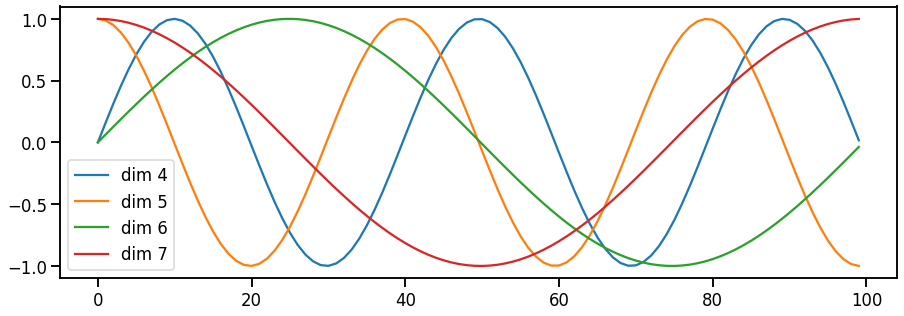

In [25]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In this tutorial, we will use positional embeddings that are initialized randomly and learned from scratch (we won't use sinusoidal embeddings). To build such positional embeddings, we can resort to nn.Embedding layer in the following way:

In [26]:
positional_encoding = nn.Embedding(max_seq_len, d_model) # contains "max_seq_len" positional embeddings

Let's pick a positional encoding for third token in the input

In [27]:
print("Positional encoding for w in position 3: ", positional_encoding(torch.tensor([2]))) # 0-indexed, so refers to third positional embedding

Positional encoding for w in position 3:  tensor([[ 0.1642,  0.3744,  0.3704,  0.7420,  1.3308, -0.4382, -1.6271,  0.8957,
          2.3701,  1.3993]], grad_fn=<EmbeddingBackward>)




![](https://drive.google.com/uc?export=view&id=1nis5Pu3GDOUU4608i1qAzs-tRjVSk18L)

So far, we have seen how to compose the input to a transformer block, by summing the input token embeddings with their corresponding positional encodings. 

The inputs and output of the multi-headed self-attention module are connected by residual connectors and a layer normalization layer. The output of the multi-headed self-attention is then passed to a two-layered feed-forward network which has its inputs/outputs similarly connected in a residual fashion with layer normalization. The sublayer residual connectors with layer norm is expressed as:

$X = LayerNorm(F_S(X)) + X$

where $F_S$ is the sub-layer module which is either the multi-headed self-attention or the position-wise feed-forward layers.

### Multi-Head Self-Attention

The Transformer model leverages a multi-headed self-attention mechanism. The key idea behind the mechanism is to learn an alignment (similar to Bahdanau's concatenative/additive attention, which we saw in the last tutorial) in which each element in the sequence learns to gather from other tokens in the sequence. The operation for a single head is defined as:

$A_i = Softmax(\alpha Q_i K_i^T)V_i$

![](https://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png)

Picture Courtesy: https://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png


where $Q_i = W_i^q X$, $K_i = W_i^k X$, $V_i^v = W_i^v X$ are linear transformations applied on the temporal dimension of the input sequence. $W_i^q \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W_i^k \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W_i^v \in \mathbb{R}^{d_{\text{model}} \times d_v}$ are the weight matrices (parameters) for the query, key and value projections and project the input $X$ to an output tensor of d dimensions. Let us denote the number of heads by $h$.

$X$ is a matrix of size $\mathbb{R}^N \times \mathbb{R}^{d_{model}}$, and $\alpha$ is a scaling factor that is typically set to $\frac{1}{\sqrt{{d_{model}}}}$.  The outputs of heads $A_1$...$A_{h}$ are concatenated together and passed into a dense layer. The output $Y$ can thus be expressed as $Y$ $=$ $W^o \in \mathbb{R}^{hd_v \times d_{\text{model}}}$ \[$A_1$ ...$A_{h}]$, where $W^o$ is an output linear projection. Note that the computation of A is typically done in a parallel fashion.

![](https://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png)

Picture Courtesy: https://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png

Let's see some sample code for computing attention ($A_h$):

In [28]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.
As discussed before, parameter matrices for linear projection for query, key, value, concatenated multihead output include $W^q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^k_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^v_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^o \in \mathbb{R}^{d_v \times d_{\text{model}}}$. In the work of Vaswani et al., they employ $h=8$ parallel attention layers, or heads. For each of these they use $d_k=d_v=d_{\text{model}}/h=64$. 

A sample code for implementing multi-head attention include:

In [29]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [30]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # q, k, v: [batch_size, n_head, seq_len, d_k]
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### Position-wise feed-forward layers

![](https://drive.google.com/uc?export=view&id=1nis5Pu3GDOUU4608i1qAzs-tRjVSk18L)

The outputs of the self-attention module is then passed into a two-layered feed-forward network with ReLU activations. This feed-forward layer operates on each position independently hence the term position-wise. This is expressed as follows:

$\text{FFN}(X_A) = max(0, X_A W_1 + b_1) W_2 + b_2$

### Putting it all together

Each transformer block can be expressed as:

$X_A = \text{LayerNorm}(\text{MultiheadSelfAttention}(X)) + X$

$X_B = \text{LayerNorm}(\text{FFN}(X_A)) + X_A$

where X is the input of the Transformer block and $X_B$ is the output of the Transformer block.

### Transformers

It is important to note the differences in the mode of usage of the Transformer block. Transformers can primarily be used in three ways, namely:
- encoder-only (e.g., for classification), 
- decoder-only (e.g., for language modeling), 
- encoder-decoder (e.g., for machine translation, which is our focus)

In encoder-decoder mode, there are usually multiple multi-headed self-attention modules, including a standard self-attention in both the encoder and the decoder, along with an encoder-decoder cross-attention that allows the decoder to utilize information from the encoder. This influences the design of the self-attention mechanism. In the encoder mode, there is no restriction or constraint that the self-attention mechanism has to be causal, i.e., dependent solely on the present and past tokens. In the encoder-decoder setting, the encoder and encoder-decoder cross attention can afford to be non-causal but the decoder self-attention must be causal. The ability to support causal auto-regressive decoding is required when designing efficient self-attention mechanisms since it can be a limiting factor in many applications.



## Transformer model - Implementation

[nn.Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) module implements the entire encoder-decoder Transformer model, excluding the input token embeddings, position encodings, source and target masks. This module takes in the following parameters:
- **$d_{\text{model}}$** – the number of expected features in the encoder/decoder inputs 
- **nhead** – the number of heads in the multiheadattention models (the term 'h' in theory)
- **num_encoder_layers** - the number of sub-encoder-layers in the encoder
- **num_decoder_layers** - the number of sub-decoder-layers in the decoder
- **dim_feedforward** -  the dimension of the feedforward network model
- **dropout** - the dropout value

Let's understand `nn.Transformer` module by passing a sample batch.

Let's first convert the src and target word indices to word embeddings:






In [31]:
# word embedding layers for encoder (src) and decoder (targ)
token_embedding_encoder = nn.Embedding(num_embeddings=len(SRC.vocab), embedding_dim=512).to(device) # src vocab size x embedding size
print("token_embedding_encoder = ", token_embedding_encoder)
token_embedding_decoder = nn.Embedding(num_embeddings=len(TRG.vocab), embedding_dim=512).to(device) # targ vocab size x embedding size
print("token_embedding_decoder = ", token_embedding_decoder)

# print the shape tensors in sample batch: src and targ
print("src shape = ", src.shape) # src. max. seq len x batch size
print("targ shape = ", trg.shape) # targ. max. seq len x batch size

# pass the word indices to embedding layer to get embeddings
src_token_embeddings = token_embedding_encoder(src.to(device))
print("src_token_embeddings shape = ", src_token_embeddings.shape) # src. max. seq len x batch size x embedding size
targ_token_embeddings = token_embedding_decoder(trg.to(device))
print("targ_token_embeddings shape = ", targ_token_embeddings.shape) # targ. max. seq len x batch size x embedding size


token_embedding_encoder =  Embedding(6469, 512)
token_embedding_decoder =  Embedding(5893, 512)
src shape =  torch.Size([25, 16])
targ shape =  torch.Size([23, 16])
src_token_embeddings shape =  torch.Size([25, 16, 512])
targ_token_embeddings shape =  torch.Size([23, 16, 512])


Having built word embeddings, we can now build position embeddings for both encoder and decoder. Let's start by defining the position embedding layer.

In [32]:
# position embedding layers for encoder (src) and decoder (targ)
maximum_sentence_len = 200 # this will be the maximum length of source and target sentence that our model can process (can have separate maximum lengths for both encoder and decoder)
position_embedding_encoder = nn.Embedding(num_embeddings=maximum_sentence_len, embedding_dim=512).to(device) # maximum_sentence_len x embedding size
print("position_embedding_encoder = ", position_embedding_encoder)
position_embedding_decoder = nn.Embedding(num_embeddings=maximum_sentence_len, embedding_dim=512).to(device) # maximum_sentence_len x embedding size
print("position_embedding_decoder = ", position_embedding_decoder)

position_embedding_encoder =  Embedding(200, 512)
position_embedding_decoder =  Embedding(200, 512)


Now we can create the positional input for both encoder and decoder. For a single example setting, the positional inputs can be created as follows:

In [33]:
# if the no. of tokens in the source sentence is `src_seq_len`
src_seq_len = src.size(0)
src_position = torch.arange(0, src_seq_len)
print('positional input for a single source example = ', src_position, src_position.shape)

# if the no. of tokens in the target sentence is `trg_seq_len`
trg_seq_len = trg.size(0)
trg_position = torch.arange(0, trg_seq_len)
print('positional input for a single target example = ', trg_position, trg_position.shape)

positional input for a single source example =  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]) torch.Size([25])
positional input for a single target example =  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22]) torch.Size([23])


If we have a batch of examples, the positional inputs can be extended to batch as follows:

In [34]:
batch_size = src.size(1) # size of the current batch
src_position = (torch.arange(0, src_seq_len).unsqueeze(1).expand(src_seq_len, batch_size).to(device))
print('positional input for a source batch = ', src_position, src_position.shape)

positional input for a source batch =  tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],

Similarly for the target batch,

In [35]:
batch_size = trg.size(1) # size of the current batch
targ_position = (torch.arange(0, trg_seq_len).unsqueeze(1).expand(trg_seq_len, batch_size).to(device))
print('positional input for a target batch = ', targ_position, targ_position.shape)

positional input for a target batch =  tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],

The positional embeddings can be obtained by passing the position input to position embeddings layer of encoder and decoder:

In [36]:
src_pos_embeddings = position_embedding_encoder(src_position)
print('positional input for source = ', src_position.shape)
print('positional embeddings for source = ', src_pos_embeddings.shape)

targ_pos_embeddings = position_embedding_encoder(targ_position)
print('positional input for target = ', targ_position.shape)
print('positional embeddings for target = ', targ_pos_embeddings.shape)

positional input for source =  torch.Size([25, 16])
positional embeddings for source =  torch.Size([25, 16, 512])
positional input for target =  torch.Size([23, 16])
positional embeddings for target =  torch.Size([23, 16, 512])


Having built word embedding and position embedding, we can now add both the embeddings to create the input embedding to Transformer module

In [37]:
src_input_embedding = src_token_embeddings + src_pos_embeddings
print('input embedding for source = ', src_input_embedding.shape)
targ_input_embedding = targ_token_embeddings + targ_pos_embeddings
print('input embedding for target = ', targ_input_embedding.shape)

input embedding for source =  torch.Size([25, 16, 512])
input embedding for target =  torch.Size([23, 16, 512])


We can optionally add dropout to both the input embeddings before feeding as an input to Transformer.

Similar to our last week's tutorial, we need to create a binary mask for the source tokens that marks the pad tokens.

In [38]:
# create the source (pad) mask
mask_src = (src == SRC.vocab.stoi[SRC.pad_token]).transpose(0, 1).to(device) # batch size x src max. seq length
print(mask_src)

tensor([[False, False, False, False, False, False, False, False, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True,  True,  True, 

We can now create an instance from `nn.Transformer` module:

In [39]:
# check doc for details about the input arguments
# https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
embed_dim = 512 #  the number of expected features in the encoder/decoder inputs
nhead = 8 # the number of heads in the multiheadattention models
num_encoder_layers = 2 # the number of sub-encoder-layers in the encoder
num_decoder_layers = 2 # the number of sub-decoder-layers in the decoder
dim_feedforward = 1024 # the dimension of the feedforward network model
dropout = 0.1 # the dropout value (default=0.1)
transformer_layer = nn.Transformer(d_model=embed_dim, nhead=nhead, num_encoder_layers=num_encoder_layers, dropout=dropout, num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward).to(device)
print(transformer_layer)

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): 

We have created all the inputs that we need to pass to Transformer module except one: **target mask** that makes the decoder attend to only the past decoder context while predicting the next token.

In [40]:
# create the target (self-attention) mask 
targ_seq_len = trg.size(0)
mask_targ = transformer_layer.generate_square_subsequent_mask(targ_seq_len).to(device)
print("mask target = ", mask_targ, mask_targ.shape)  # targ. seq len x targ. seq len

mask target =  tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
     

Let's now pass all the tensor we've created to transformer layer:

In [41]:
print("shape of src_input_embedding = ", src_input_embedding.shape) # src. seq len x batch size x embedding size 
print("shape of targ_input_embedding = ", targ_input_embedding.shape)  # targ. seq len x batch size x embedding size 
print("shape of mask_src = ", mask_src.shape) #  batch size x src. seq len
print("shape of mask_targ = ", mask_targ.shape) # targ. seq len x targ. seq len
output = transformer_layer(src_input_embedding, targ_input_embedding, src_key_padding_mask=mask_src, tgt_mask=mask_targ)
print("shape of the transformer output = ", output.shape) # targ. seq len x batch size x embedding size 

shape of src_input_embedding =  torch.Size([25, 16, 512])
shape of targ_input_embedding =  torch.Size([23, 16, 512])
shape of mask_src =  torch.Size([16, 25])
shape of mask_targ =  torch.Size([23, 23])
shape of the transformer output =  torch.Size([23, 16, 512])


Having seen an example for using Transformer module, let's implement the Transformer model for machine translation:

In [42]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, embed_dim, nhead, num_encoder_layers, dropout, num_decoder_layers, dim_feedforward, maximum_sentence_len=200):
        super(Transformer, self).__init__()

        # get initial hyper-parameters
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.embed_dim = embed_dim
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.dropout = dropout
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward

        # add embedding layers
        self.token_embedding_encoder = nn.Embedding(num_embeddings=self.src_vocab, embedding_dim=self.embed_dim)
        self.token_embedding_decoder = nn.Embedding(num_embeddings=self.trg_vocab, embedding_dim=self.embed_dim)
        self.position_embedding_encoder = nn.Embedding(num_embeddings=maximum_sentence_len, embedding_dim=self.embed_dim)
        self.position_embedding_decoder = nn.Embedding(num_embeddings=maximum_sentence_len, embedding_dim=self.embed_dim)

        # Encoder-Decoder Transformer
        self.transformer = nn.Transformer(d_model=self.embed_dim, nhead=self.nhead, num_encoder_layers=self.num_encoder_layers, dropout=self.dropout, num_decoder_layers=self.num_decoder_layers, dim_feedforward=self.dim_feedforward)

        # output layer to predict next token
        self.decoder = nn.Linear(self.embed_dim, self.trg_vocab)
        self.drop_layer = nn.Dropout()

    def forward(self, src, tgr):
        # read shapes
        # src = src_seq_len x batch_size
        # tgr = targ_seq_len x batch_size
        src_seq_len, batch_size = src.shape
        targ_seq_len, _ = tgr.shape

        # create position input for encoder
        src_position = (torch.arange(0, src_seq_len).unsqueeze(1).expand(src_seq_len, batch_size).to(device))
        # src_position = src_seq_len x batch_size

        # create position input for decoder
        targ_position = (torch.arange(0, targ_seq_len).unsqueeze(1).expand(targ_seq_len, batch_size).to(device))
        # src_position = targ_seq_len x batch_size

        # input embedding by merging token embedding with position embedding
        embed_src = self.drop_layer((self.token_embedding_encoder(src) + self.position_embedding_encoder(src_position)))
        embed_tgr = self.drop_layer((self.token_embedding_decoder(tgr) + self.position_embedding_decoder(targ_position)))
        # embed_src = src_seq_len x batch_size x d_model
        # embed_src = targ_seq_len x batch_size x d_model

        # create mask for source
        mask_src = (src == SRC.vocab.stoi[SRC.pad_token]).transpose(0, 1).to(device)
        # mask_src = batch_size x src_seq_len

        # create mask for target
        mask_targ = self.transformer.generate_square_subsequent_mask(targ_seq_len).to(device)
        # mask_targ = targ_seq_len x targ_seq_len

        # feed via transformer
        output = self.transformer(embed_src, embed_tgr, src_key_padding_mask=mask_src, tgt_mask=mask_targ)
        # output = targ_seq_len x batch_size x d_model

        # transform the output to match no of. tokens in target vocab 
        output = self.decoder(output) 
        # output = targ_seq_len x batch_size x targ_vocab_size

        return output

Let's set the hyperparameters and create a model instance:

In [43]:
# hyperparameters
src_vocab = len(SRC.vocab)
trg_vocab = len(TRG.vocab)
embed_dim = 512
nhead = 4
num_encoder_layers = 2
dropout = 0.1 
num_decoder_layers = 2
dim_feedforward = 512
learning_rate = 1e-4

# model instance
model = Transformer(src_vocab, trg_vocab, embed_dim, nhead, num_encoder_layers, dropout, num_decoder_layers, dim_feedforward).to(device)


Let's define the train logic (for a single epoch).

In [44]:
def train(model, iterator, optimizer, criterion):
    manual_seed = 77
    torch.manual_seed(manual_seed)
    if n_gpu > 0:
        torch.cuda.manual_seed(manual_seed)
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.SRC.to(device)
        trg = batch.TRG.to(device)
        # src = src seq len x batch size
        # trg = targ seq len x batch size

        optimizer.zero_grad()
        
        output = model(src, trg[:-1, :]) # for target, provide targ seq len-1 tokens for each sentence
        
        #output = [targ seq len-1, batch size, output dim]

        output = output.reshape(-1, output.shape[2])
        target = trg[1:].reshape(-1)

        # loss function works only 2d logits, 1d targets
        # so flatten the trg, output tensors. Ignore the <sos> token
        # target shape shape should be [(targ seq len - 1) * batch_size]
        # output shape should be [(targ seq len - 1) * batch_size, output_dim]
        loss = criterion(output, target)
        
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


Let's define the inference logic for evaluating the quality of the model based on BLEU score

In [48]:
def inference(model, file_name, src_vocab, trg_vocab, attention = False, max_trg_len = 64):
    '''
    Function for translation inference

    Input: 
    model: translation model;
    file_name: the directoy of test file that the first column is target reference, and the second column is source language;
    trg_vocab: Target torchtext Field
    attention: the model returns attention weights or not.
    max_trg_len: the maximal length of translation text (optinal), default = 64

    Output:
    Corpus BLEU score.
    '''
    from nltk.translate.bleu_score import corpus_bleu
    from nltk.translate.bleu_score import sentence_bleu
    from torchtext.data import TabularDataset
    from torchtext.data import Iterator

    # convert index to text string
    def convert_itos(convert_vocab, token_ids):
        list_string = []
        for i in token_ids:
            if i == convert_vocab.vocab.stoi['<eos>']:
                break
            else:
                token = convert_vocab.vocab.itos[i]
                list_string.append(token)
        return list_string

    test = TabularDataset(
      path=file_name, # the root directory where the data lies
      format='tsv',
      skip_header=True, # if your tsv file has a header, make sure to pass this to ensure it doesn't get proceesed as data!
      fields=[('TRG', trg_vocab), ('SRC', src_vocab)])

    test_iter = Iterator(
      dataset = test, # we pass in the datasets we want the iterator to draw data from
      sort = False, 
      batch_size=1,
      sort_key=None,
      shuffle=False,
      sort_within_batch=False,
      device = device,
      train=False
    )
  
    model.eval()
    all_gold_trg_tokids = []
    all_translated_trg_tokids = []

    TRG_PAD_IDX = trg_vocab.vocab.stoi[trg_vocab.pad_token]

    with torch.no_grad():
    
        for i, batch in enumerate(test_iter):

            src = batch.SRC.to(device)
            #src = [src len, batch size]

            trg = batch.TRG.to(device)

            #src = GOLD_SRC.to(device)
            #trg = GOLD_TRG.to(device)
            #trg = [trg len, batch size]

            batch_size = trg.shape[1]

            outputs = [trg_vocab.vocab.stoi["<sos>"]]
            for i in range(max_trg_len):
                trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)
                
                output = model(src, trg_tensor)

                topv, topi = output[-1,0,:].topk(1)
                cur_decoded_token = topi.squeeze().detach()  # detach from history as input
                outputs.append(cur_decoded_token.item())

                if cur_decoded_token.item() == trg_vocab.vocab.stoi["<eos>"]:
                    break
            all_translated_trg_tokids.append(outputs[1:-1])
            all_gold_trg_tokids.append([ trg[idx, 0].item() for idx in range(1, trg.size(0)-1)])
    
    # convert token ids to token strs
    all_gold_text = []
    all_translated_text = []
    for i in range(len(all_gold_trg_tokids)): 
        all_gold_text.append([[trg_vocab.vocab.itos[idx] for idx in all_gold_trg_tokids[i]]])
        all_translated_text.append([trg_vocab.vocab.itos[idx] for idx in all_translated_trg_tokids[i]])
        
    corpus_bleu_score = corpus_bleu(all_gold_text, all_translated_text)  
    return corpus_bleu_score

Let's define the evaluation logic to compute the quality of the model based on the loss.

In [53]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.SRC.to(device)
            trg = batch.TRG.to(device)

            output = model(src, trg[:-1, :]) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            #output = output[1:].view(-1, output_dim)
            #trg = trg[1:].view(-1)

            output = output.reshape(-1, output.shape[2])
            target = trg[1:].reshape(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, target)

            epoch_loss += loss.item()
            #break
        
    bleu = inference(model, "./drive/MyDrive/Colab_Notebooks/eng-fre/val_eng_fre.tsv", SRC, TRG, False, 64)
    return epoch_loss / len(iterator) , bleu

Let's perform the full-training of the Transformer model:

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# set the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# create the loss function
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
print('<pad> token index: ', TRG_PAD_IDX)
## we will ignore the pad token in true target set
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# numer of epochs (hyperparameter)
N_EPOCHS = 15

# initial best valid loss
best_valid_loss = float('inf')

# kick-start training
print('Training started...')
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion)
    valid_loss, bleu = evaluate(model, val_iter, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Create checkpoint at end of each epoch
    state_dict_model = model.state_dict() 
    state = {
        'epoch': epoch,
        'state_dict': state_dict_model,
        'optimizer': optimizer.state_dict()
        }

    torch.save(state, "./drive/MyDrive/Colab_Notebooks/ckpt_attn/seq2seq_"+str(epoch+1)+".pt")

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\t Val. BLEU: {bleu:7.3f}')

# Evaluate the model after the last epoch on the test set
test_loss, bleu_test = evaluate(model, test_iter, criterion)
print(f'\t Test BLEU: {bleu_test:7.3f}')

## Reference:

https://nlp.seas.harvard.edu/2018/04/03/attention.html#position-wise-feed-forward-networks

https://pytorch.org/docs/master/nn.html#transformerencoderlayer

https://pytorch.org/docs/master/_modules/torch/nn/modules/transformer.html#Transformer